## predicting Oscar winner_ modeling(write)

### 부문별 모델 생성
## 3. 각본상

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 


### 데이터 불러오기 및 전처리

In [3]:
final_write = pd.read_csv("./data/final_write.csv")
final_write.drop("Documentary", axis =1, inplace =True) # 다큐멘터리 장르는 없으므로 의미없는 칼럼, 삭제한다.
final_write = pd.concat([final_write,pd.get_dummies(final_write['Date'])], axis=1) # Date 칼럼 원핫인코딩
final_write['win'] = final_write['win'].apply(lambda x : 1 if (x == True) else 0) # win 컬럼 01 변환
final_write.head()

,year_film,year_ceremony,ceremony,category,name,film,win,Gross,Date,Runtime,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1976,1977,49,WRITING,William Goldman,All the Presidents Men,1,7.060000e+07,Apr,138,...,0,0,0,0,0,0,0,0,0,0
1,1976,1977,49,WRITING,Robert Getchell,Bound for Glory,0,5.986694e+07,Dec,147,...,1,0,0,0,0,0,0,0,0,0
2,1976,1977,49,WRITING,Federico Fellini Bernardino Zapponi,Fellinis Casanova,0,5.986694e+07,Feb,155,...,0,1,0,0,0,0,0,0,0,0
3,1976,1977,49,WRITING,Nicholas Meyer,The Seven-per-cent Solution,0,5.986694e+07,May,113,...,0,0,0,0,0,0,1,0,0,0
4,1976,1977,49,WRITING,Steve Shagan David Butler,Voyage of the Damned,0,5.986694e+07,Dec,155,...,1,0,0,0,0,0,0,0,0,0


### Train_data, Train_label 분리

In [4]:
train_data = final_write.drop(["win","year_film","year_ceremony","ceremony","category","name","film","Date"],axis=1)
train_label = final_write["win"]

### 연속형 변수 StandardScaler로 평균 0, 표준편차 1 이 되는 값으로 변경 

스케일링  
스케일링은 자료 집합에 적용되는 전처리 과정으로 모든 자료에 선형 변환을 적용하여 전체 자료의 분포를 평균 0, 분산 1이 되도록   만드는 과정이다.스케일링은 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지하고 독립 변수의 공분산 행렬의 조건수  (condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상시킨다.  
  

scikit-learn에서는 다음과 같은 스케일링 클래스를 제공한다.  
  
* StandardScaler(X): 평균이 0과 표준편차가 1이 되도록 변환.  
* RobustScaler(X): 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환.  
* MinMaxScaler(X): 최대값이 각각 1, 최소값이 0이 되도록 변환.  
* MaxAbsScaler(X): 0을 기준으로 절대값이 가장 큰 수가 1또는 -1이 되도록 변환.  

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()

train_data[['Gross', 'Runtime', 'nominations', 'imdb', 'tomato', 'Metacr', 'imdbVotes']] = scaler.fit_transform(train_data[['Gross', 'Runtime', 'nominations', 'imdb', 'tomato', 'Metacr', 'imdbVotes']])
train_data.head()

,Gross,Runtime,Awards,nominations,imdb,tomato,Metacr,imdbVotes,Thriller,Short,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0.116426,0.505114,13.0,-0.605325,0.853840,0.561695,0.079397,-0.425297,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.033252,0.802919,4.0,-0.761356,-0.467703,-0.282318,-1.000839,-0.707598,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,-0.033252,1.067635,6.0,-0.886180,-0.845287,-0.301017,-0.201153,-0.701082,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,-0.033252,-0.322122,1.0,-0.886180,-1.600454,-0.402891,-0.201153,-0.708929,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,-0.033252,1.067635,1.0,-0.839371,-2.166830,-0.764610,-0.201153,-0.713678,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


### train_test_split 을 이용하여 train, test set분리

In [7]:
from sklearn.model_selection import train_test_split

In [8]:


X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size =0.25, random_state=123, stratify = train_label)

# stratify : train_label의 비율을 살려 테스트와 트레인 부분을 나눈다. 

### SMOTE 를 이용. 비대칭 데이터 문제를 해결하기 위한 오버샘플링
SMOTE : 기존의 소수의 값 주변의 값들로 데이터 생성  

### 언더 샘플링
* RandomUnderSampler: random under-sampling method
* TomekLinks: Tomek’s link method
* CondensedNearestNeighbour: condensed nearest neighbour method
* OneSidedSelection: under-sampling based on one-sided selection method
* EditedNearestNeighbours: edited nearest neighbour method
* NeighbourhoodCleaningRule: neighbourhood cleaning rule

### 오버 샘플링
* RandomOverSampler: random sampler
* ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning  
* SMOTE: Synthetic Minority Over-sampling Technique

###  복합 샘플링
* SMOTEENN: SMOTE + ENN
* SMOTETomek: SMOTE + Tomek

In [9]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [10]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train,y_train)

In [12]:
print("X_train 데이터 수 : {}".format(len(X_train)))
print("X_train_over 데이터 수 : {}".format(len(X_train_over)))
print("y_train 데이터 비율 : \n{}".format(y_train.value_counts()))
print("y_train_over 데이터 비율 : \n{}".format(y_train_over.value_counts()))


X_train 데이터 수 : 322
X_train_over 데이터 수 : 516
y_train 데이터 비율 : 
0    258
1     64
Name: win, dtype: int64
y_train_over 데이터 비율 : 
1    258
0    258
Name: win, dtype: int64


### StratifiedKFold를 이용하여 비율에 맞게 데이터를 나눈다. 

일반적으로 회귀에는 기본 k-겹 교차검증을 사용하고, 분류에는 StratifiedKFold를 사용한다. 파라미터 찾을때 사용

In [11]:
from sklearn.model_selection import StratifiedKFold

In [12]:
skf = StratifiedKFold(n_splits=10)

### Decision Tree

* max_depth를 임의로 정해주지 않으면 자동으로 모든 leaf가 pure해질때까지 나눈다. 그말인 즉슨, 모든 leaf가 확실한 leaf이고, 확률은 모두 해당 클래스에 대해서만 1이라는 것이다.

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
DTC = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best' )

DTC.fit(X_train_over,y_train_over)

pred_DTC = DTC.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred_DTC)))

confusion_matrix(y_test,pred_DTC)

f1 score : 0.3881


array([[54, 32],
       [ 9, 13]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기¶

In [28]:
from sklearn.model_selection import GridSearchCV

In [18]:
DT = DecisionTreeClassifier(random_state =1234)
parameters = {
    "criterion" :[ "entropy"],
    "max_depth" :[3,4,5,6,7],
    "splitter" :["best"],
    "max_leaf_nodes" :[2,3,4,5],
    "min_samples_leaf" : [1],
    "min_samples_split" : [2]
    
    
}

grid_dt = GridSearchCV(DT,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1 )
grid_dt.fit(X_train_over, y_train_over)

pred = grid_dt.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.3881


array([[54, 32],
       [ 9, 13]], dtype=int64)

In [19]:
grid_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

### Decision Tree 시각화

In [19]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


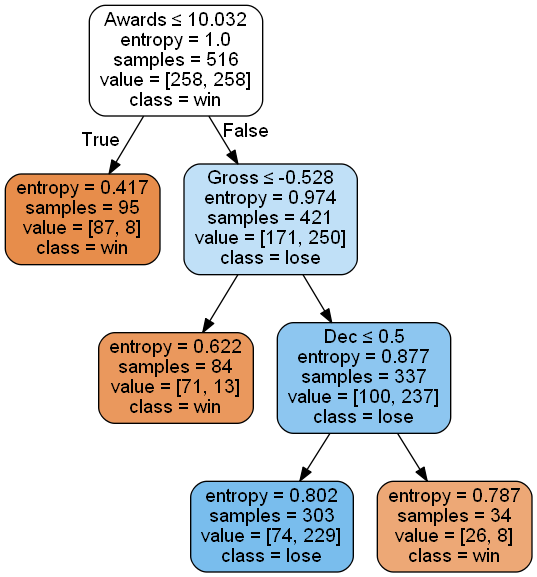

In [21]:
dot_data = StringIO()

export_graphviz(DTC, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=["win", "lose"],
                 feature_names=X_train.columns
              )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### plot 한글 패치

In [22]:
%matplotlib inline

import os
from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl

In [23]:
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc('font', family=font_name)


### Decision Tree 특성 중요도 plot

In [17]:
def plot_feature_importances_final_best(model):
    plt.figure(figsize=(9, 9))
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Us

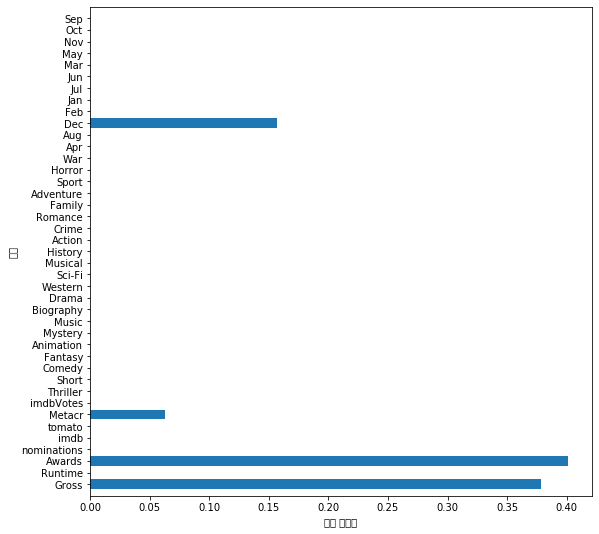

In [22]:
plot_feature_importances_final_best(DTC)

### 앙상블(emsemble)
앙상블이란 여러 개의 결정 트리(Decision Tree)를 결합하여 하나의 결정 트리보다 더 좋은 성능을 내는 머신러닝 기법이다.  
크게 3종류로 나눌 수 있다. 

* Bagging
* Boosting
* Voting

Bagging : Bagging은 Bootstrap Aggregation의 약자. 배깅은 샘플을 여러 번 뽑아(Bootstrap) 각 모델을 학습시켜 결과물을 집계(Aggregration)하는 방법. RandomForest

Boosting : 가중치를 활용하여 약 분류기를 강 분류기로 만드는 방법. 

<img src = "./img/bagging_and_boosting.png">

출처: swallow.github.io

### GBC(GradientBoostingClassifier)

여러개의 Decision Tree를 묶어 강력한 모델을 만드는 기법.
이전 tree의 오차를 보완하는 방식으로 tree를 만든다. 

* learning_rate를 높이면 보정을 강하게 하기 때문에 복잡한 모델을 만든다.
* n_estimator 값을 키우면 ensemble에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 train 세트를 더 정확하게 fitting한다.(오버피팅 주의)
* 기본값: max_depth=3, learning_rate=0.1

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [102]:
GBC = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GBC.fit(X_train_over, y_train_over)

pred_GBC= GBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred_GBC)))

confusion_matrix(y_test,pred_GBC)

f1 Score : 0.5128


array([[79,  7],
       [12, 10]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [28]:
GB = GradientBoostingClassifier(random_state =1234)
parameters = {
    "max_depth" :[4,5,6,10],
    "learning_rate" :[0.1, 0.5,0.05,0.01],
    "n_estimators" :[100,10 , 20, 30]
   
    
    
}

grid_gb = GridSearchCV(GB,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1 )
grid_gb.fit(X_train_over, y_train_over)

pred = grid_gb.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.5128


array([[79,  7],
       [12, 10]], dtype=int64)

In [29]:
grid_gb.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### GBC 특성 중요도 Plot

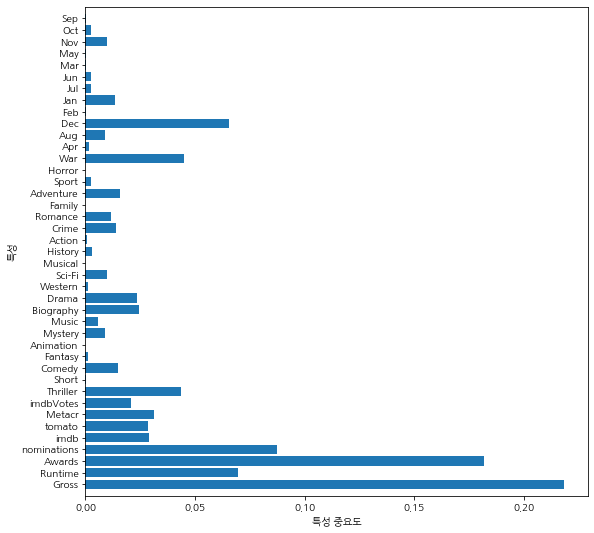

In [103]:
plot_feature_importances_final_best(GBC)

### XGBC(XGBClassifier)

Gradient Boosting(경사하강법)의 단점을 보완한 부스터   
CART(Classification and Regresstion Tree)기반 : Addictive learning = 더해서 배운다. 분류와 회귀 둘다 가능하다. 

일반 파라미터 : 도구 모양을 결정하는 파라미터. linear or tree
* booster : ['gbtree', 'gblinear', 'dart']
* nthread
* num_feature

부스팅 파라미터 : 트리마다 가지를 칠 때 적용하는 옵션. 선택한 booster마다 파라미터가 다름 

학습과정 파라미터 : 최적화 퍼포먼스를 결정하는 파라미터 

커맨드라인 파라미터 : epoch랑 비슷 

#### 파라미터 최적화 
- learning_rate, default = 0.3, 0~1 사이, 학습 단계별로 가중치를 얼만큼 줄까를 결정. 낮을수록 보수적
- gamma : min split loss, default = 0, 0~무한대 사이, 의사결정나무가 가지를 칠때 타켓변수에 대해 얼마나 설명할수 있나. 클수록 보수적, 가지를 안치려고 함
- max_depth : default = 6, 0~무한대.

xgboost 파라미터 :
https://xgboost.readthedocs.io/en/latest/parameter.html
https://apple-rbox.tistory.com/6

In [31]:
import xgboost as xgb
from xgboost import XGBClassifier

In [104]:
XGBC = XGBClassifier(ase_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 
                     
b
XGBC.fit(X_train_over, y_train_over)

pred_XGBC= XGBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred_XGBC)))

confusion_matrix(y_test,pred_XGBC)

f1 Score : 0.4615


array([[78,  8],
       [13,  9]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [33]:
XGB = XGBClassifier(random_state =1234, n_jobs=-1)
parameters = {
    "n_estimators" :[10,20,30,100],
    "base_score" :[0.5, 0.1, 1],
    "booster":['gbtree'],
    "learning_rate" : [0.05, 0.01,0.001],
    "max_depth" :[8, 10,15]
}

grid_xgb = GridSearchCV(XGB,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_xgb.fit(X_train_over, y_train_over)

pred = grid_xgb.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.4615


array([[78,  8],
       [13,  9]], dtype=int64)

In [34]:
grid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### XGBoostClassifier 특성 중요도 plot

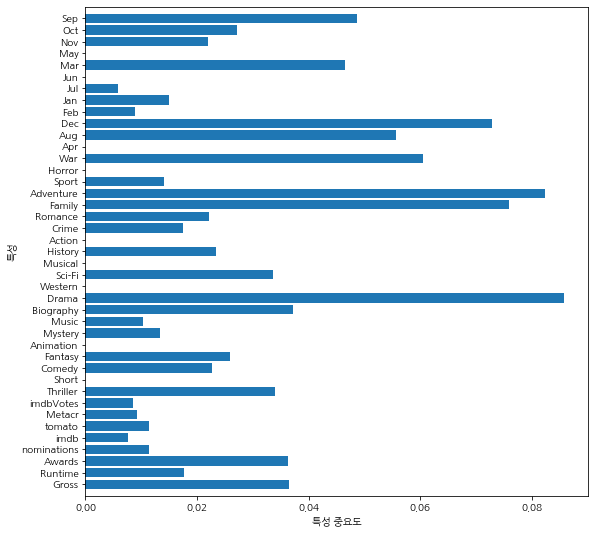

In [105]:
plot_feature_importances_final_best(XGBC)

### Light GBMC(light gradient boosting machine)
XGBoost의 느린 단점을 보완하기 위해 나옴

다른 Booster의 트리는 level-wise(균형 중심)분할을 이용. depth를 줄이고 균형을 맞춤.
lightgbm은 leaf-wise(리프 중심)분할. 균형을 맞추지 않고 계속 분할. 비대칭적이고 깊은 트리, 동일한 leaf를 생성할 때 level-wise보다 손실이 적다.

파라미터 튜닝 : https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [25]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [26]:
LGBC = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.15, max_depth=-1,
               min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=30, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBC.fit(X_train_over, y_train_over)

pred_LGBC = LGBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred_LGBC)))

confusion_matrix(y_test,pred_LGBC)

f1 Score : 0.5116


array([[76, 10],
       [11, 11]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [29]:
LGB =LGBMClassifier(random_state =1234, n_jobs=-1)
parameters = {
    "n_estimators" :[10,20,30,100],
   "learning_rate":[0.1,0.15, 0.05, 0.01],
    "num_leaves" : [31],
    "min_child_samples" : [1,2,3,4, 5]
}
grid_lgb = GridSearchCV(LGB,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_lgb.fit(X_train_over, y_train_over)

pred = grid_lgb.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.5116


array([[76, 10],
       [11, 11]], dtype=int64)

In [107]:
grid_lgb.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.15, max_depth=-1,
               min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=30, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### LGBMClassifier 특성 중요도 plot

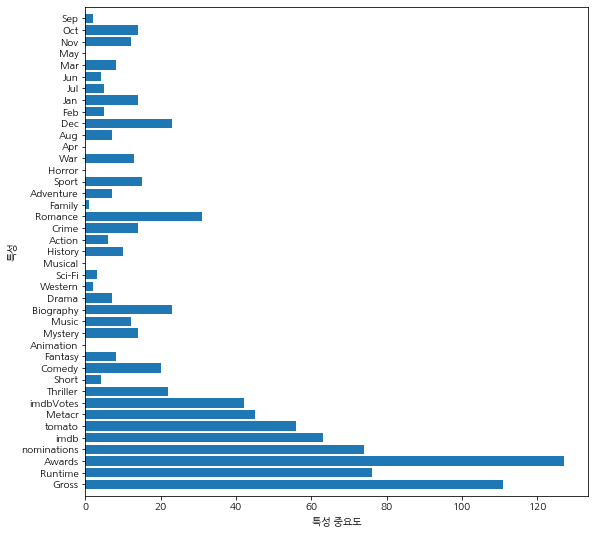

In [109]:
plot_feature_importances_final_best(LGBC)

### RFC(RandomForestClassifier)
여러 개의 의사결정나무를 만들고, 그들의 다수결로 결과를 결정하는 방법
classification 과 regression 에 모두 쓸 수 있다.  

- N-estimator : 랜덤포레스트 안에 만들어지는 의사결정나무 갯수. 트리가 많아지면 속도가 느려지고 너무 트리가 크면 오히려 정확도가 낮아진다. 그러나 일반적으론 트리가 많아질수록 분류를 잘하게 되므로 적절한 trade-off 필요하다.

- Max-depth : 랜덤포레스트 안에 있는 각 의사결정나무의 깊이를 설정. 트리가 깊어질수록 더 잘게 분류를 시키므로 일반적으론 정확도가 높아진다.

- Min-samples-split : 내부 노드에 데이터를 얼마 만큼씩 최소한 넣을 것인가 설정. 10%~100%로 설정. 100%로 갈수록 underffiting이 일어나서 정확도가 낮아진다. 

- Min-samples-leaf : 리프 노드에 데이터를 얼마 만큼씩 최소한 넣을 것인가 설정. 10%~100%로 설정. 100%로 갈수록 underffiting이 일어나서 정확도가 낮아진다.

- Max-feature : 가장 잘 분류할 feature의 갯수를 설정. max_features 값을 크게 하면 랜덤 포레스트의 트리들은 매우 비슷해지고 가장 두드러진 특성을 이용해 데이터에 잘 맞춰진다. max_features를 낮추면 랜덤 포레스트 트리들은 많이 달라지고 각 트리는 데이터에 맞추기 위해 깊이가 깊어지게 된다.



In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
RFC =RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

RFC.fit(X_train_over, y_train_over)

pred_RFC = RFC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred_RFC)))

confusion_matrix(y_test,pred_RFC)

f1 Score : 0.4103


array([[77,  9],
       [14,  8]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [31]:
RF =RandomForestClassifier(random_state =1234, n_jobs=-1)

parameters = {
    "n_estimators" :[10,20,25,30,100],
    "min_samples_leaf" : [1,2,3,4,5],
    "min_samples_split" : [2,3,4,5],
    "max_features" : [5, 10, 20,30,0]
  
}
grid_rf = GridSearchCV(RF,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_rf.fit(X_train_over, y_train_over)

pred = grid_rf.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)



f1 Score : 0.4103


array([[77,  9],
       [14,  8]], dtype=int64)

In [32]:
grid_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

### RFC 특성 중요도 Plot

C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Us

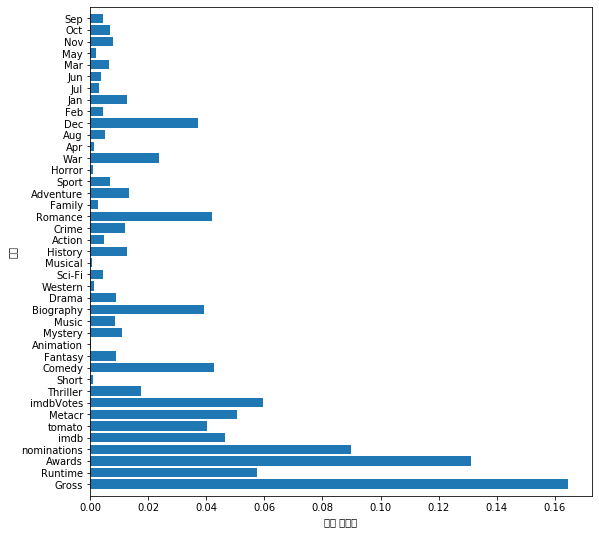

In [33]:
plot_feature_importances_final_best(RFC)

### 특성 중요도 top 7으로만 RFC 돌리기

In [34]:
df = pd.DataFrame()
df['import']= grid_rf.best_estimator_.feature_importances_
df['ft']  = X_train_over.columns
df.sort_values('import', ascending=False, inplace = True)
df.reset_index(inplace=True)
df

,index,import,ft
0,0,0.164558,Gross
1,2,0.131157,Awards
2,3,0.089659,nominations
3,7,0.059481,imdbVotes
4,1,0.057505,Runtime
5,6,0.050456,Metacr
6,4,0.046380,imdb
7,10,0.042721,Comedy
8,23,0.042057,Romance
9,5,0.040333,tomato


In [37]:
RFC1 =RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

RFC1.fit(X_train_over[list(df.loc[:7,'ft'])], y_train_over)

pred_RFC1 = RFC1.predict(X_test[list(df.loc[:7,'ft'])])

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred_RFC1)))

confusion_matrix(y_test,pred_RFC1)

f1 Score : 0.3913


array([[71, 15],
       [13,  9]], dtype=int64)

In [116]:
RF =RandomForestClassifier(random_state =1234, n_jobs=-1)

parameters = {
    "n_estimators" :[10,20,25,30,100],
    "min_samples_leaf" : [1,2,3,4,5],
    "min_samples_split" : [2,3,4,5],
    "max_features" : [2,3,4,5,6,7,8]
  
}
grid_rf1 = GridSearchCV(RF,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)

grid_rf1.fit(X_train_over[list(df.loc[:7,'ft'])], y_train_over)

pred = grid_rf1.predict(X_test[list(df.loc[:7,'ft'])])

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)


f1 Score : 0.4762


array([[76, 10],
       [12, 10]], dtype=int64)

In [117]:
grid_rf1.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

f1 Score가 0.4107-> 0.4762 로 변화하였다.    
특성 중요도가 높은 feature 8개를 가지고 RandomForest를 돌렸을때, max_features=3 일때 f1 score가 0.4762이다. 
특성을 많이 선택하는 것이 좋은 모델은 아닌 것을 알 수 있다. 

### LogisticRegression
* 범주형 변수를 예측하는 회귀모델 
* odds(승산) = 발생할 확률 / 발생하지 않을 확률 = p / (1-p)
* log Odds ratio
* 로짓변환 : y -> log(y/1-y) =log(Odds) = c + ax
* sigmoid 함수 
* "독립변수 X에 대한 선형 회귀식을 X가 주어졌을 때의 반응 변수 Y의 로그 오즈에 적합시킨다."
* "편의(bias)가 없는 타당한 계수 추정치를 계산할 수 있다." -> 불균형한 데이터를 오버샘플링하면 모집단과 특성이 달라지는데 이러면 수치가 달라짐. 로지스틱 회귀는 계수추정치는 변하지 않고 절편만 바뀜. = 편의 없이 계수 추정치를 구하는 방법이다. 


In [50]:
from sklearn.linear_model import LogisticRegression

In [122]:
LRC = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=1234, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
LRC.fit(X_train_over, y_train_over)
pred_LRC = LRC.predict(X_test)
print("f1 score : {0:.4f}".format(f1_score(y_test,pred_LRC)))
confusion_matrix(y_test,pred_LRC)

f1 score : 0.5238


array([[77,  9],
       [11, 11]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [119]:
LR =LogisticRegression(random_state =1234, n_jobs=-1)

parameters = {
     "penalty" : ['l1', 'l2', 'elasticnet', 'none'],
    "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
  
}
grid_lr = GridSearchCV(LR,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_lr.fit(X_train_over, y_train_over)

pred = grid_lr.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)



f1 Score : 0.5238


array([[77,  9],
       [11, 11]], dtype=int64)

In [120]:
grid_lr.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=1234, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

### SVM(Support Vector Machine)

* 분류 경계선의 margin을 maxium으로 만드는 모델 
* '선'을 넘어서 '면'으로도 분류 경계선을 만들 수 있다. -> 시간이 오래걸림
* 복잡한 비선형의 의사결정영역을 모형화 할 수 있기 때문에 매우 정확하고, 다른 모델보다 오버피팅되는 경향이 적다.  
#  
* hard : 전부 철저하게 분리. 현실적으로 어렵다. -> soft 벡터 마진이 나옴
* soft : 여유 변수(slack variable)을 둔다. 약간의 오류를 인정함.   
#  
* 로버스트(robust)하다= 아웃라이어(outlier)의 영향을 받지 않는다는 뜻 -> 마진이 크면 robustness도 최대가 됨  
#  
* 커널 트릭(Kernel Trick) = 저차원 공간(low dimensional space)을 고차원 공간(high dimensional space)으로 매핑해주는 작업. 고차원에서 선형라인을 구해서 저차원에 맵핑. 저차원에서 비선형 라인을 구한다. 
* kernel parameter : linear, polynomial, sigmoid, rbf 등  
* C : Controls tradeoff detween smooth decision boundary and classfying training points correctly. 얼마나 오차를 허용할 건지...C가 크면 구불구불...
* Gamma: Defines how far the influence of a single training point reaches . reach = 결정선의 굴곡에 영향을 주는 데이터 범위.  
감마가 크다 = reach가 작다. 경계선이 더 구불구불... 경계선에 가까운 포인트들만 영향을 준다 -> 하나의 영향력이 큼 -> 구불구불  
감마가 작다 = reach가 멀다. 경계선이 직선에 가까움. 포인트 하나하나가 모두 경계선에 영향을 준다 -> 하나의 영향력이 크지 않다. -> 직선이다.
* kernel, C, gamma 값을 튜닝하는게 포인트!!!

In [72]:
from sklearn.svm import SVC

In [133]:
from sklearn.svm import SVC
SVC = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=1234, shrinking=True,
    tol=0.001, verbose=False) 
SVC.fit(X_train_over,y_train_over)
pred_SVC = SVC.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred_SVC)))
confusion_matrix(y_test,pred_SVC)

f1 score : 0.2222


array([[68, 18],
       [17,  5]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [58]:
SV =SVC(random_state =1234)

parameters = {
     "kernel" : [ 'linear', 'poly', 'sigmoid', 'rbf'],
    "C" : [2,5,10,4],
    "gamma" :['scale', 'auto']
  
}
grid_sv = GridSearchCV(SV,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_sv.fit(X_train_over, y_train_over)

pred = grid_sv.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)



f1 Score : 0.2222


array([[68, 18],
       [17,  5]], dtype=int64)

In [123]:
grid_sv.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=1234, shrinking=True,
    tol=0.001, verbose=False)

### DNN
* activation : 활성화 함수 설정합니다.  
    -‘linear’ : 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력으로 나옵니다.  
    -‘relu’ : rectifier 함수, 은익층에 주로 쓰입니다.  
    -‘sigmoid’ : 시그모이드 함수, 이진 분류 문제에서 출력층에 주로 쓰입니다.  
    -‘softmax’ : 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰입니다.  

* categorical_crossentropy : 다중 분류 손실함수. one-hot encoding 클래스. 확률로 나타냄 [0.2,0.3,0.5]
* sparse_categorical_crossentropy : 다중 분류 손실함수. categorical과 비슷하나 integer type 클래스다. [1,2,3]
* binary_crossentropy : 0,1 분류. activation을 sigmoid 사용해야함. 


<img src = "./img/activation.png">

In [60]:
# 3.4 텐서플로 2.0 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import os

In [61]:
X_train_over_np= X_train_over.to_numpy()
y_train_over_np =y_train_over.to_numpy()


In [62]:
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [63]:
y_train_over_np = tf.keras.utils.to_categorical(y_train_over_np, num_classes=2)
y_test_np = tf.keras.utils.to_categorical(y_test_np, num_classes=2)

In [64]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [125]:
checkpoint_path = "training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)



model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32,activation='elu', input_shape=(41,)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=16, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Dense(units=8, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.3),

  
    
    # 분류 모델이기 때문에 최종 단에 있어서는 softmax를 활용을 해야 함!!!!
    tf.keras.layers.Dense(units=2, activation='softmax')
    #tf.keras.layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Nadam(),  loss='categorical_crossentropy', metrics=['accuracy', f1score])
#model.compile(optimizer=tf.keras.optimizers.Adam(),  loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_over_np, y_train_over_np, epochs=100, batch_size=64, validation_split=0.25 , callbacks = [cp_callback])
model.evaluate(X_test_np, y_test_np,verbose=2)



Train on 387 samples, validate on 129 samples
Epoch 1/100
 64/387 [===>..........................] - ETA: 9s - loss: 3.4699 - accuracy: 0.6094 - f1score: 0.6094
Epoch 00001: saving model to training_3/cp-0001.ckpt
387/387 [==============================] - 2s 6ms/sample - loss: 3.1343 - accuracy: 0.5814 - f1score: 0.5930 - val_loss: 6.8375 - val_accuracy: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/100
 64/387 [===>..........................] - ETA: 0s - loss: 5.0792 - accuracy: 0.5156 - f1score: 0.5156
Epoch 00002: saving model to training_3/cp-0002.ckpt
387/387 [==============================] - 0s 233us/sample - loss: 3.0408 - accuracy: 0.5736 - f1score: 0.5409 - val_loss: 4.6322 - val_accuracy: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 3/100
 64/387 [===>..........................] - ETA: 0s - loss: 1.9275 - accuracy: 0.4531 - f1score: 0.4531
Epoch 00003: saving model to training_3/cp-0003.ckpt
387/387 [==============================] - 0s 225us/sample - loss: 2.8010 - accuracy: 

Epoch 25/100
 64/387 [===>..........................] - ETA: 0s - loss: 1.1391 - accuracy: 0.6719 - f1score: 0.6719
Epoch 00025: saving model to training_3/cp-0025.ckpt
387/387 [==============================] - 0s 240us/sample - loss: 1.0102 - accuracy: 0.6072 - f1score: 0.6153 - val_loss: 0.6365 - val_accuracy: 0.7674 - val_f1score: 0.8437
Epoch 26/100
 64/387 [===>..........................] - ETA: 0s - loss: 0.8932 - accuracy: 0.5938 - f1score: 0.5937
Epoch 00026: saving model to training_3/cp-0026.ckpt
387/387 [==============================] - 0s 235us/sample - loss: 0.8767 - accuracy: 0.6512 - f1score: 0.6987 - val_loss: 0.6528 - val_accuracy: 0.7442 - val_f1score: 0.8281
Epoch 27/100
 64/387 [===>..........................] - ETA: 0s - loss: 0.9093 - accuracy: 0.6406 - f1score: 0.6406
Epoch 00027: saving model to training_3/cp-0027.ckpt
387/387 [==============================] - 0s 233us/sample - loss: 0.9969 - accuracy: 0.5917 - f1score: 0.6019 - val_loss: 0.6584 - val_accurac

Epoch 49/100
 64/387 [===>..........................] - ETA: 0s - loss: 0.8206 - accuracy: 0.6250 - f1score: 0.6250
Epoch 00049: saving model to training_3/cp-0049.ckpt
387/387 [==============================] - 0s 225us/sample - loss: 0.7395 - accuracy: 0.6460 - f1score: 0.6488 - val_loss: 0.7849 - val_accuracy: 0.6899 - val_f1score: 0.7917
Epoch 50/100
 64/387 [===>..........................] - ETA: 0s - loss: 0.8966 - accuracy: 0.6875 - f1score: 0.6875
Epoch 00050: saving model to training_3/cp-0050.ckpt
387/387 [==============================] - 0s 220us/sample - loss: 0.9161 - accuracy: 0.6098 - f1score: 0.5722 - val_loss: 0.7675 - val_accuracy: 0.6899 - val_f1score: 0.7917
Epoch 51/100
 64/387 [===>..........................] - ETA: 0s - loss: 0.7805 - accuracy: 0.5625 - f1score: 0.5625
Epoch 00051: saving model to training_3/cp-0051.ckpt
387/387 [==============================] - 0s 230us/sample - loss: 0.8783 - accuracy: 0.6227 - f1score: 0.6287 - val_loss: 0.7516 - val_accurac

Epoch 96/100
 64/387 [===>..........................] - ETA: 0s - loss: 0.6005 - accuracy: 0.6406 - f1score: 0.6406
Epoch 00096: saving model to training_3/cp-0096.ckpt
387/387 [==============================] - 0s 214us/sample - loss: 0.6831 - accuracy: 0.6408 - f1score: 0.6443 - val_loss: 0.9177 - val_accuracy: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 97/100
 64/387 [===>..........................] - ETA: 0s - loss: 0.7235 - accuracy: 0.6406 - f1score: 0.6406
Epoch 00097: saving model to training_3/cp-0097.ckpt
387/387 [==============================] - 0s 199us/sample - loss: 0.7397 - accuracy: 0.6382 - f1score: 0.6875 - val_loss: 0.9160 - val_accuracy: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 98/100
 64/387 [===>..........................] - ETA: 0s - loss: 0.7810 - accuracy: 0.6094 - f1score: 0.6094
Epoch 00098: saving model to training_3/cp-0098.ckpt
387/387 [==============================] - 0s 191us/sample - loss: 0.7372 - accuracy: 0.6382 - f1score: 0.5967 - val_loss: 0.91

[0.4956603326179363, 0.7962963, 0.80208325]

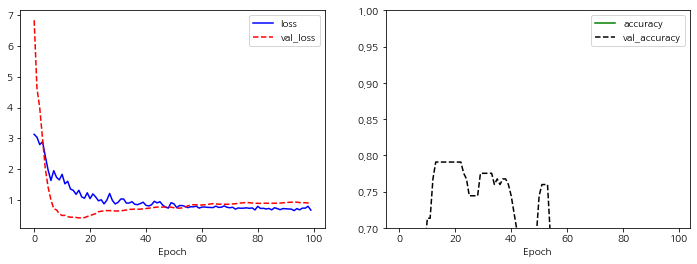

In [126]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

과대 적합을 방지하는 방법 
* 더 많은 훈련 데이터를 모읍니다.
* 네트워크의 용량을 줄입니다.tf.keras.layers.Dense(units=24)
* 가중치 규제를 추가합니다. kernel_regularizer=tf.keras.regularizers.l2(0.001)
* 드롭아웃을 추가합니다.  tf.keras.layers.Dropout(rate=0.5)

큰 모델 (dense 의 units의 값이 큰거)이 과대적합이 빨리 된다. 
<img src = "./img/loss.png">

optimizer
<img src = "./img/optimizer.jpg">

### 제일 성능이 잘나오는 가중치를 선택

In [128]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32,activation='elu', input_shape=(41,)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=16, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=8, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(rate=0.3),

    
    # 분류 모델이기 때문에 최종 단에 있어서는 softmax를 활용을 해야 함!!!!
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model2.compile(optimizer=tf.keras.optimizers.Nadam(),  loss='categorical_crossentropy', metrics=['accuracy', f1score])

model2.load_weights("training_3/cp-0018.ckpt")
model2.evaluate(X_test_np, y_test_np,verbose=2)

108/108 - 0s - loss: 0.7861 - accuracy: 0.5741 - f1score: 0.5885


[0.7860723778053567, 0.5740741, 0.5885416]

### stacking에 이용할 predict array 생성

In [129]:
pred_DNN = model2.predict(X_test_np)

In [130]:
pred_DNN1 = []
for i in range(pred_DNN.shape[0]):
    if pred_DNN[i][0] > pred_DNN[i][1]:
        pred_DNN1.append(pred_DNN[i][0]) 
    else:
        pred_DNN1.append(pred_DNN[i][1])


### votingClassifier

* hard voting: 단순 투표. 개별 모형의 결과 기준
* soft voting: 가중치 투표. 개별 모형의 조건부 확률의 합 기준    
#  
* estimators: 개별 모형 목록, 리스트나 named parameter 형식으로 입력
* voting: 문자열 {hard, soft} hard voting 과 soft voting 선택. 디폴트는 hard
* weights: 사용자 가중치 리스트

In [70]:
from sklearn.ensemble import VotingClassifier

In [135]:
vo_clf = VotingClassifier(estimators=[('DTC', DTC),('GBC', GBC),('XGBC', XGBC), ('LGBC', LGBC ), ('RFC', RFC), ('LRC', LRC),('SVC', SVC)], voting='hard')

vo_clf.fit(X_train_over,y_train_over)
pred = vo_clf.predict(X_test)
print('Hard Voting 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[DTC, GBC,XGBC,LGBC,RFC, LRC,SVC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} f1 score : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

Hard Voting 분류기 f1 score: 0.4762
DecisionTreeClassifier f1 score :  0.3881
GradientBoostingClassifier f1 score :  0.5128
XGBClassifier f1 score :  0.4615
LGBMClassifier f1 score :  0.5116
RandomForestClassifier f1 score :  0.4103
LogisticRegression f1 score :  0.5238
SVC f1 score :  0.2222


DNN은 classifier가 아니여서 votingClassifier()의 estimator에 모델을 넣을 수가 없다.  
hard voting에서 좋은 성능을 위해 좋은 성능을 내는 모델들만 이용하여 hard voting을 할 수 있다.  
이 경우에는 빼면 성능이 나빠져서 모두 넣었다. 

In [134]:
vo_clf = VotingClassifier(estimators=[('DTC', DTC),('GBC', GBC),('XGBC', XGBC), ('LGBC', LGBC ), ('RFC', RFC), ('LRC', LRC),('SVC', SVC)], voting='soft')

vo_clf.fit(X_train_over,y_train_over)
pred = vo_clf.predict(X_test)
print('Soft Voting 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[ DTC, GBC,XGBC,LGBC,RFC, LRC,SVC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} f1 score : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

Soft Voting 분류기 f1 score: 0.4878
DecisionTreeClassifier f1 score :  0.3881
GradientBoostingClassifier f1 score :  0.5128
XGBClassifier f1 score :  0.4615
LGBMClassifier f1 score :  0.5116
RandomForestClassifier f1 score :  0.4103
LogisticRegression f1 score :  0.5238
SVC f1 score :  0.2222


각본상에서는 soft voting이 hard voting보다 성능이 좋다.

In [136]:
vo_clf = VotingClassifier(estimators=[('DTC', DTC),('GBC', GBC),('XGBC', XGBC), ('LGBC', LGBC ), ('RFC', RFC), ('LRC', LRC),('SVC',SVC)], voting='soft', weights=[1,2,2,2,2,1,0.5])

vo_clf.fit(X_train_over,y_train_over)
pred = vo_clf.predict(X_test)
print('Soft-weighted Voting 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[ DTC, GBC,XGBC,LGBC,RFC, LRC,SVC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} f1 score : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

Soft-weighted Voting 분류기 f1 score: 0.4878
DecisionTreeClassifier f1 score :  0.3881
GradientBoostingClassifier f1 score :  0.5128
XGBClassifier f1 score :  0.4615
LGBMClassifier f1 score :  0.5116
RandomForestClassifier f1 score :  0.4103
LogisticRegression f1 score :  0.5238
SVC f1 score :  0.2222


soft voting 보다 모델에게 가중치를 준 soft-weighted 성능이 더 좋다.

### EnsembleVoteClassifier을 이용하여 voting
VotingClassifier, hard로 한거랑 값이 같다

In [78]:
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import model_selection

In [137]:


eclf = EnsembleVoteClassifier(clfs=[ DTC, GBC,XGBC, LGBC , RFC, LRC , SVC], weights=[1,2,2,2,2,1,1])

eclf.fit(X_train_over,y_train_over)
pred = eclf.predict(X_test)
print('EnsembleVoteClassifier 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[ DTC, GBC,XGBC,LGBC,RFC, LRC, SVC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} f1 score : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

EnsembleVoteClassifier 분류기 f1 score: 0.4762
DecisionTreeClassifier f1 score :  0.3881
GradientBoostingClassifier f1 score :  0.5128
XGBClassifier f1 score :  0.4615
LGBMClassifier f1 score :  0.5116
RandomForestClassifier f1 score :  0.4103
LogisticRegression f1 score :  0.5238
SVC f1 score :  0.2222


### baggingClassifirer

* 부트스트랩 어그리게이팅 Bootstrap AGGregING의 약어
* 데이터양이 적으면 성능이 안좋다. 
* 대표적인 bagging 앙상블 = RandomForest. 위에서 랜포 성능이 안좋았던걸 기억하면..... 안좋음  
* Note that using larger subsamples is not guaranteed to improve your results. In bagging there is a tradeoff between base model accuracy and the gain you get through bagging. The aggregation from bagging may improve the ensemble greatly when you have an unstable model, yet when your base models are more stable — been trained on larger subsamples with higher accuracy — improvements from bagging reduces.  
#  
* base_estimator: 기본 모형
* n_estimators: 모형 갯수. 디폴트 10
* bootstrap: 데이터의 중복 사용 여부. 디폴트 True
* max_samples: 데이터 샘플 중 선택할 샘플의 수 혹은 비율. 디폴트 1.0
* bootstrap_features: 특징 차원의 중복 사용 여부. 디폴트 False
* max_features: 다차원 독립 변수 중 선택할 차원의 수 혹은 비율 1.0

In [80]:
from sklearn.ensemble import BaggingClassifier

In [145]:
bag_clf = BaggingClassifier(base_estimator=vo_clf, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('voting Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

voting Bagging 분류기 f1 score: 0.4390


In [139]:
bag_clf = BaggingClassifier(base_estimator=GBC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('GBC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

GBC Bagging 분류기 f1 score: 0.4500


In [140]:
bag_clf = BaggingClassifier(base_estimator=XGBC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('XGBC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

XGBC Bagging 분류기 f1 score: 0.4651


In [141]:
bag_clf = BaggingClassifier(base_estimator=LGBC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('LGBC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

LGBC Bagging 분류기 f1 score: 0.4545


In [142]:
bag_clf = BaggingClassifier(base_estimator=RFC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('RFC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

RFC Bagging 분류기 f1 score: 0.4615


In [143]:
bag_clf = BaggingClassifier(base_estimator=LRC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('LRC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

LRC Bagging 분류기 f1 score: 0.4737


### stacking

* 모델에서 나온 예측값을 하나의 데이터 프레임으로 만들어 다시한번 모델에 넣어 예측한다. 
* 각 모델에서 나온 pred 들은 컬럼으로 생성됨. transpose로 row로 변경해서 데이터 프레임 모양을 맞춰줘야한다. 

In [146]:
X_test.shape

(108, 41)

In [147]:
df_stacking = np.array([pred_DTC, pred_GBC, pred_XGBC, pred_LGBC, pred_RFC, pred_LRC, pred_SVC])
df_stacking.shape

(7, 108)

In [148]:
df_stacking = np.transpose(df_stacking)
df_stacking.shape

(108, 7)

In [149]:
XGBC_stacking = XGBClassifier()
XGBC_stacking.fit(df_stacking,y_test)
pred = XGBC_stacking.predict(df_stacking)
print('stacking with XGBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with XGBC f1 score: 0.5000


In [150]:
XGBC.fit(df_stacking,y_test)
pred = XGBC.predict(df_stacking)
print('stacking with XGBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with XGBC f1 score: 0.5000


In [151]:
GBC_stacking = GradientBoostingClassifier()
GBC_stacking.fit(df_stacking,y_test)
pred = GBC_stacking.predict(df_stacking)
print('stacking with GBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with GBC f1 score: 0.5455


In [152]:
GBC.fit(df_stacking,y_test)
pred = GBC.predict(df_stacking)
print('stacking with GBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with GBC f1 score: 0.5161


In [153]:
RFC_stacking = RandomForestClassifier()
RFC_stacking.fit(df_stacking,y_test)
pred = RFC_stacking.predict(df_stacking)
print('stacking with RFC_stacking f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with RFC_stacking f1 score: 0.6154


각본상은 RFC로 stacking했을 때 성능이 가장 좋다.  
위에서 만든 RFC 모델은 feature갯수를 지정해놔서 사용하면 에러가 발생함.

In [154]:
LRC_stacking = LogisticRegression()
LRC_stacking.fit(df_stacking,y_test)
pred = LRC_stacking.predict(df_stacking)
print('stacking with LRC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with LRC f1 score: 0.4516


In [155]:
LRC.fit(df_stacking,y_test)
pred = LRC.predict(df_stacking)
print('stacking with LRC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with LRC f1 score: 0.4848


### stacking - DNN포함

In [156]:
df_stacking = np.array([pred_DTC, pred_GBC, pred_XGBC, pred_LGBC, pred_RFC, pred_LRC, pred_SVC, pred_DNN1])
df_stacking.shape

(8, 108)

In [157]:
df_stacking = np.transpose(df_stacking)
df_stacking.shape

(108, 8)

In [158]:
XGBC_stacking = XGBClassifier()
XGBC_stacking.fit(df_stacking,y_test)
pred = XGBC_stacking.predict(df_stacking)
print('stacking with XGBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with XGBC f1 score: 0.7568


In [159]:
XGBC.fit(df_stacking,y_test)
pred = XGBC.predict(df_stacking)
print('stacking with XGBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with XGBC f1 score: 0.7568


DNN을 포함하여 stacking하면 f1 score가 0.7568까지 좋아진다.